This Notebook contains an example of using the given VaLLA implementation over 1D regression datasets.

# Imports

In [1]:
# Notebook reload options
%load_ext autoreload
%autoreload 2

In [2]:

# Global Imports
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.cluster.vq import kmeans2

# Local Imports
sys.path.append("..")
from utils.pytorch_learning import fit_map, fit, forward
from src.valla import VaLLARegression, VaLLARegressionBackend
from src.ella import ELLA_Regression
from utils.models import get_mlp, create_ad_hoc_mlp
from laplace import Laplace

from utils.dataset import get_dataset

# Experimental settings

Theese are the parameters that determine the experiments. Most of these values are set to their default value. Please refer to `utils/process_flass.py` to know more about each parameter.

In [3]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,
        "iterations": 20000,
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1
}

Set seed for reproductibility.

In [4]:
torch.manual_seed(params["seed"])

Load Dataset and desired split.

In [5]:
dataset = get_dataset("synthetic2")
train_dataset, train_test_dataset, test_dataset = dataset.get_split()

Number of samples:  400
Input dimension:  1
Label dimension:  1
Labels mean value:  0
Labels standard deviation:  1


Create Data loaders for training and test partitions.

In [6]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
train_test_loader = DataLoader(train_test_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# MAP Learning

In [7]:
f = get_mlp(
    train_dataset.inputs.shape[1],
    train_dataset.targets.shape[1],
    params["bnn_structure"],
    params["activation"],
    device=params["device"],
    dtype=params["dtype"],
)

# Define optimizer and compile model
opt = torch.optim.Adam(f.parameters(), lr=params["MAP_lr"])
criterion = torch.nn.MSELoss()

# Set the number of training samples to generate
# Train the model
start = timer()

loss = fit_map(
    f,
    train_loader,
    opt,
    criterion=torch.nn.MSELoss(),
    use_tqdm=True,
    return_loss=True,
    iterations=12000,
    device=params["device"],
)
end = timer()

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


Training :   1%|          | 145/12000 [00:00<00:32, 360.31 iteration/s]

Training : 100%|██████████| 12000/12000 [00:27<00:00, 430.19 iteration/s]


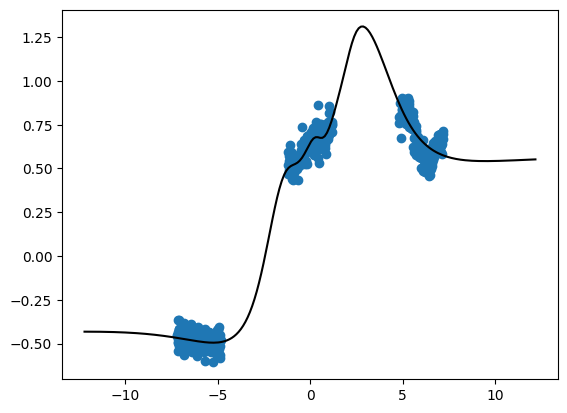

In [8]:

plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")



sort = np.argsort(test_dataset.inputs.flatten())


plt.plot(
    test_dataset.inputs.flatten()[sort],
    f(torch.tensor(test_dataset.inputs)).detach().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.show()

# LLA

## Full LLA

In [9]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "full"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

prior_std = np.sqrt(1 / np.exp(log_prior.detach().numpy())).item()
log_variance = 2*log_sigma.detach().numpy().item()



100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


In [10]:
print("Optimal GP prior std: ", prior_std)
print("Optimal GP likelihoog log variance: ", log_variance)

Optimal GP prior std:  2.157249656053849
Optimal GP likelihoog log variance:  -5.534579457457951


In [11]:
def distribution_plot(model_predictive, name = None):
    plt.rcParams["pdf.fonttype"] = 42
    plt.figure(figsize=(16,7))
    mean, var = model_predictive(torch.tensor(test_dataset.inputs, dtype = params["dtype"]))
    mean = mean.detach().numpy()
    var = var.detach().numpy() + np.exp(log_variance)
    std = np.sqrt(var).flatten()
    sort = np.argsort(test_dataset.inputs.flatten())

    fig = plt.scatter(train_dataset.inputs, 
                    train_dataset.targets, 
                    color = "black")

    plt.plot(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort],
        color="cornflowerblue",
    )
    plt.fill_between(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort] - 2 * std[sort],
        mean.flatten()[sort] + 2 * std[sort],
        alpha=0.2,
        color="cornflowerblue",
    )

    #plt.axis('off')
    plt.ylim(-2.5 ,5)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig("../demos/plots/" + name+ ".pdf", format="pdf", bbox_inches='tight')
    plt.show()

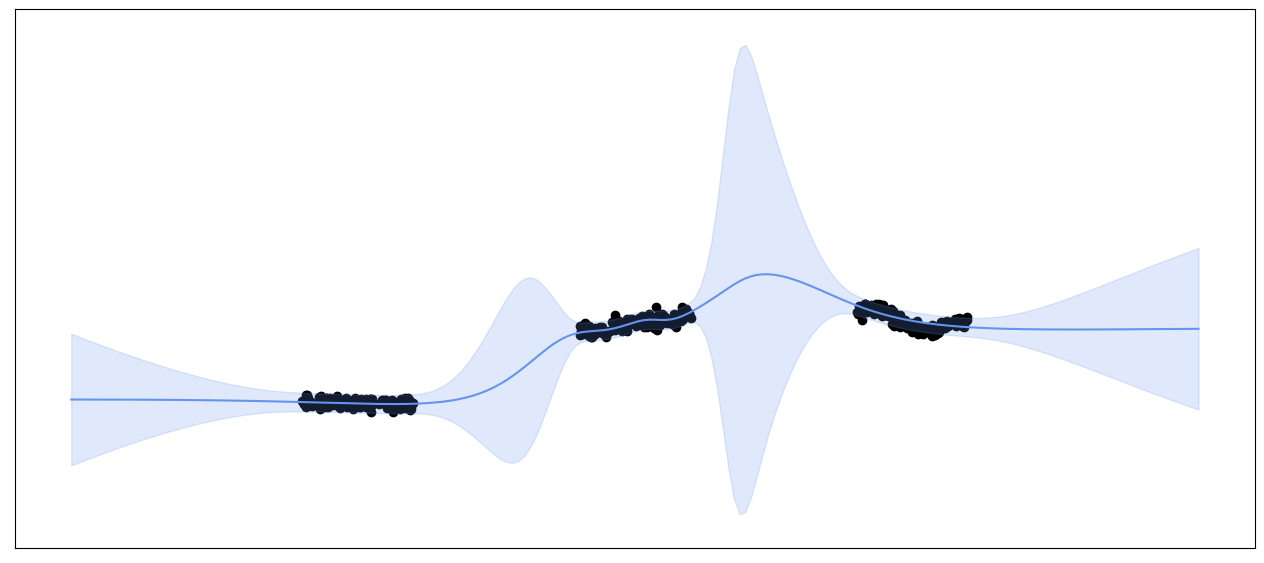

In [12]:
distribution_plot(la._glm_predictive_distribution, "LLA")

## KFAC-LLA

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 754.36it/s]


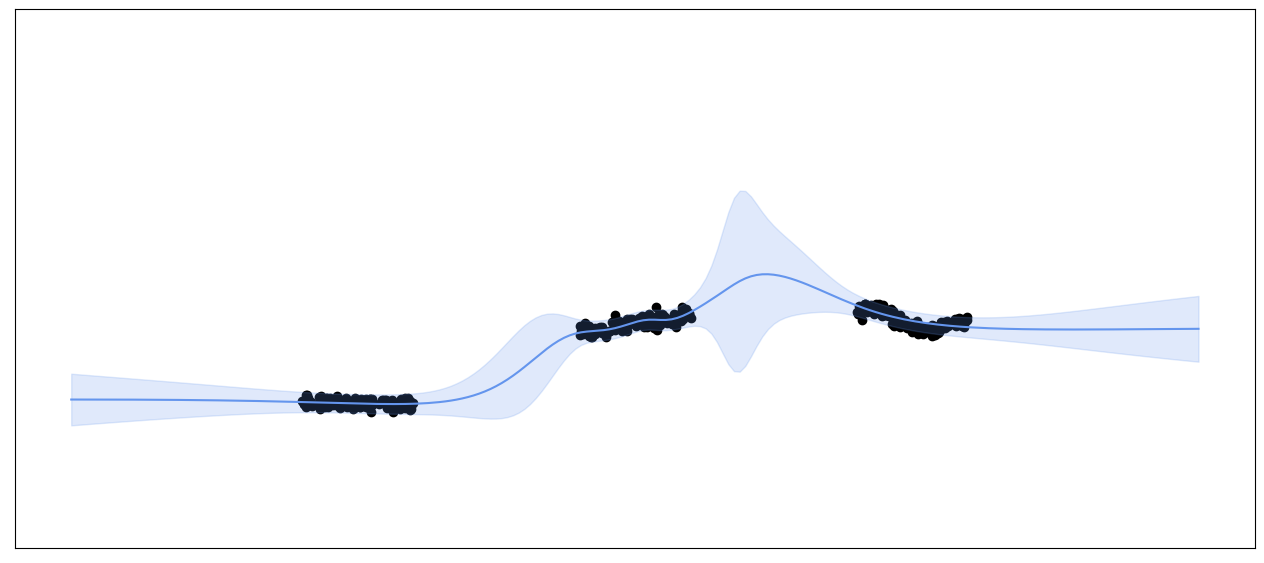

In [13]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "kron"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
distribution_plot(la._glm_predictive_distribution, "LLA-KFAC")

## Last-layer LLA

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 753.27it/s]


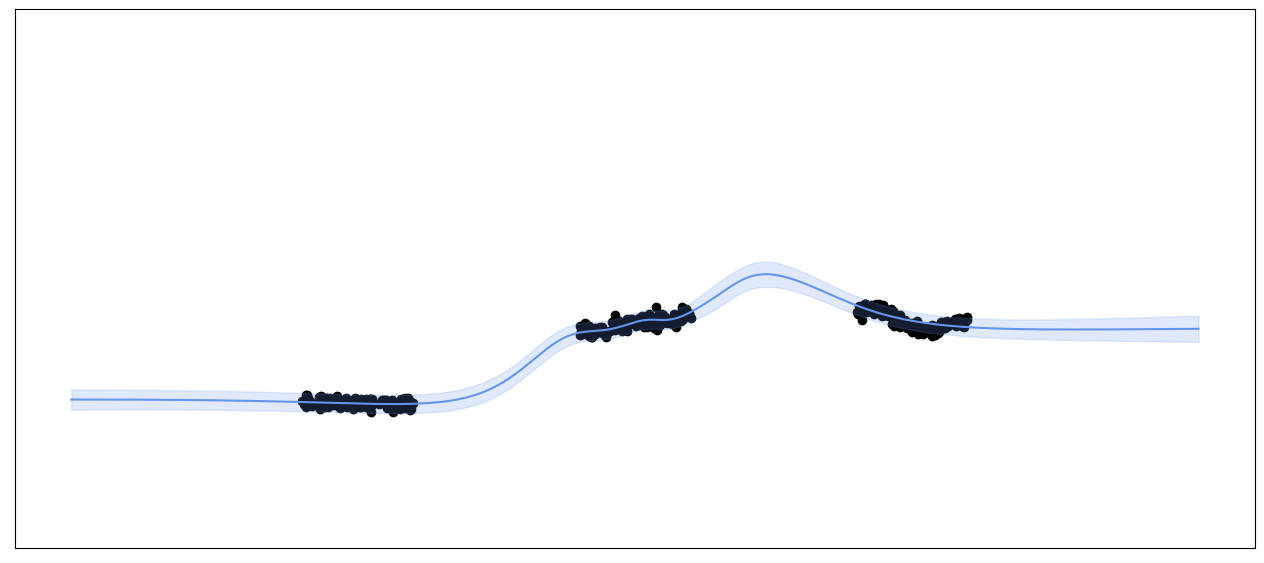

In [14]:
# 'all', 'subnetwork' and 'last_layer'
subset = "last_layer"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "full"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
distribution_plot(la._glm_predictive_distribution, "LL-LLA")

## Diagonal LLA

100%|██████████| 100/100 [00:00<00:00, 902.79it/s]


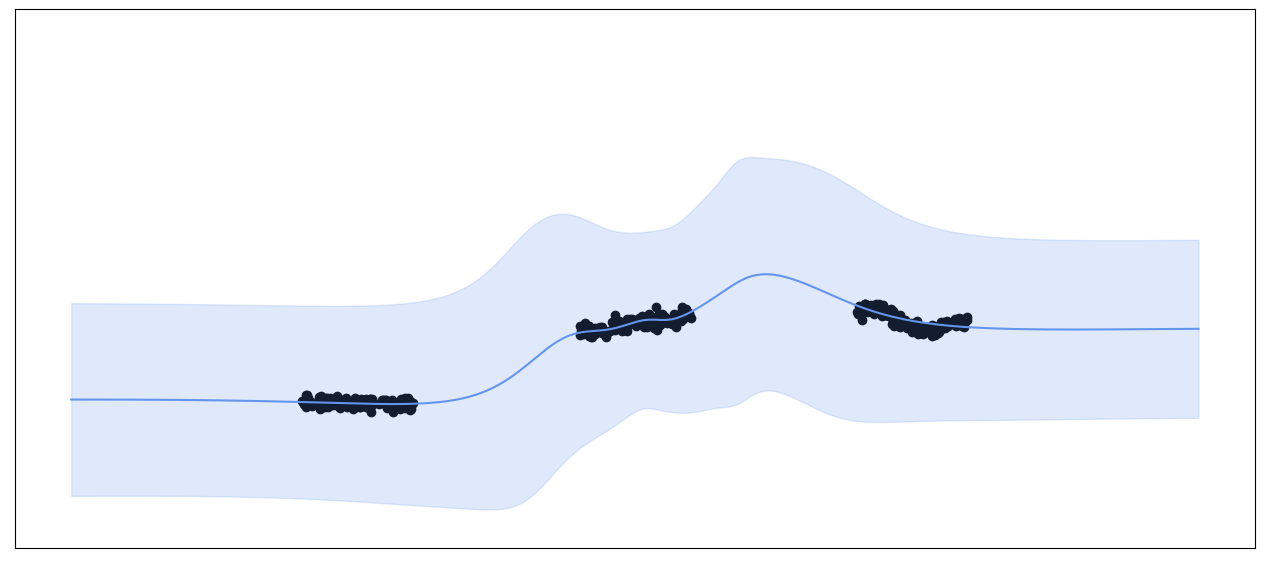

In [15]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "diag"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
distribution_plot(la._glm_predictive_distribution, "Diag-LLA")

# ELLA

In [16]:
ella = ELLA_Regression(
    create_ad_hoc_mlp(f),
    f.output_size,
    20,
    20,
    prior_std=prior_std,
    log_variance = log_variance,
    seed=params["seed"],
    y_mean=train_dataset.targets_mean,
    y_std=train_dataset.targets_std,
    device=params["device"],
    dtype=params["dtype"],
)

In [17]:
ella.fit_loader_val(
            torch.tensor(train_dataset.inputs, 
                         device=params["device"], 
                         dtype=params["dtype"]),
            torch.tensor(train_dataset.targets,
                         device=params["device"], 
                         dtype=params["dtype"]),
            train_loader,
            val_loader = None,
            verbose = True,
        )

Training : 100%|██████████| 4/4 [00:00<00:00, 316.29iteration/s]


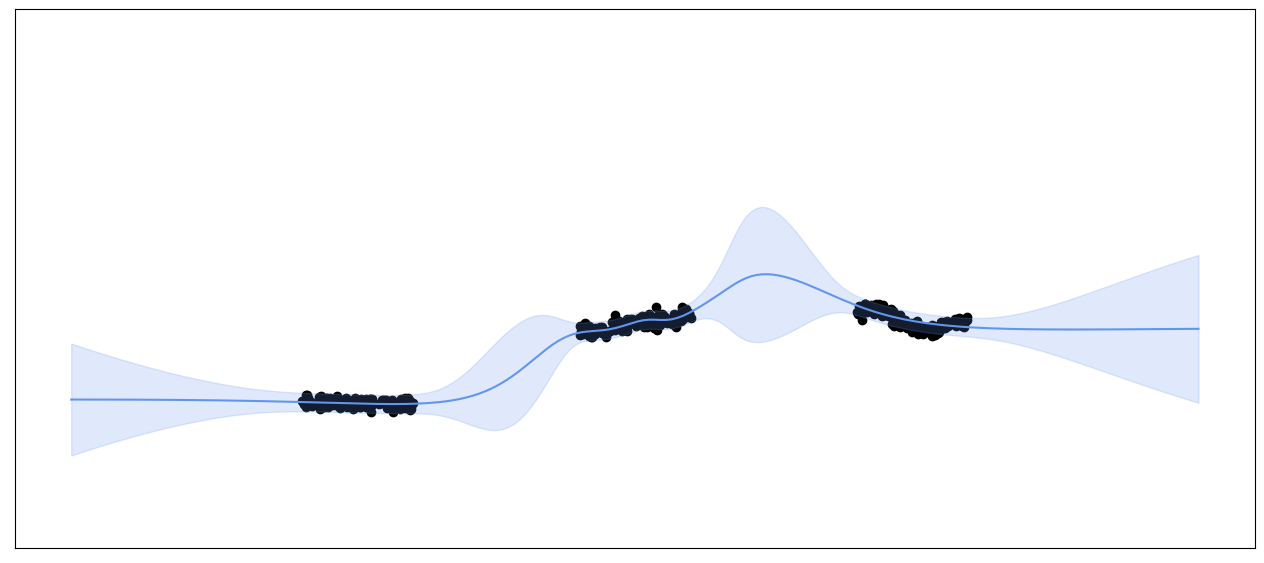

In [18]:
distribution_plot(ella.predict_f, "ELLA")

# VaLLA

Get initial values for inducing points.

In [19]:
Z = kmeans2(train_dataset.inputs, params["num_inducing"], 
            minit="points", seed=params["seed"])[0]
Z.shape


(20, 1)

In [20]:
rng = np.random.default_rng(1234)
Z = rng.normal(size = (20, 1))

Define DVIP model.

Backend or not can be used, in case of using the backend change `VaLLARegression` for `VaLLARegressionBackpack` and un-comment the backend line.

In [21]:
from src.backpack_interface import BackPackInterface
backend = BackPackInterface(f, train_dataset.output_dim)

In [22]:
valla = VaLLARegression(
    create_ad_hoc_mlp(f),
    Z,
    alpha=params["bb_alpha"],
    prior_std=prior_std,
    log_variance=log_variance,
    #backend = backend,
    num_data=train_dataset.inputs.shape[0],
    output_dim=1,
    track_inducing_locations=True,
    y_mean=train_dataset.targets_mean,
    y_std=train_dataset.targets_std,
    device=params["device"],
    dtype=params["dtype"],
)

Initializing inducing classes with 1 different classes


Freeze hyper-parameters and show all trainable ones.

In [23]:
valla.freeze_ll()
valla.freeze_prior()
valla.print_variables()


---- MODEL PARAMETERS ----
 inducing_locations: (20, 1)
                     [-1.60383681  0.06409991 ...  0.52013416 -1.00216579]
 L: (210)
    [1. 0. ... 0. 1.]

---------------------------




Start training.

In [24]:
opt = torch.optim.Adam(valla.parameters(), lr=0.001)

loss = fit(
    valla,
    train_loader,
    opt,
    use_tqdm=True,
    return_loss=True,
    iterations=20000,
    device=params["device"],
)

Training :   0%|          | 12/20000 [00:00<07:36, 43.80 iteration/s]

Training : 100%|██████████| 20000/20000 [04:17<00:00, 77.58 iteration/s] 


Let's show the training loss.

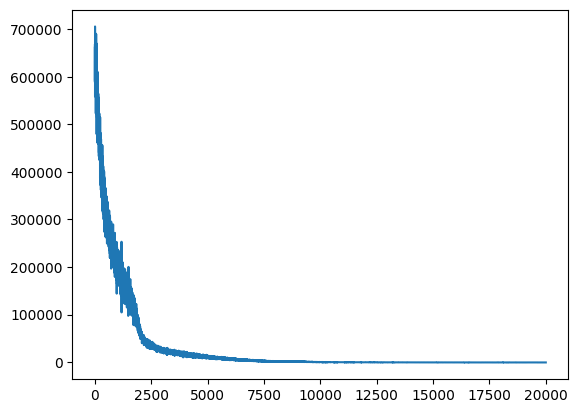

In [25]:
plt.plot(np.array(loss[0]))

These are the learned parameters.

In [26]:
valla.print_variables()


---- MODEL PARAMETERS ----
 inducing_locations: (20, 1)
                     [-4.68984777 -0.14842304 ...  0.81021081 -4.55696512]
 L: (210)
    [ 2.45928366 -2.01323373 ...  9.81038147  6.71672998]

---------------------------




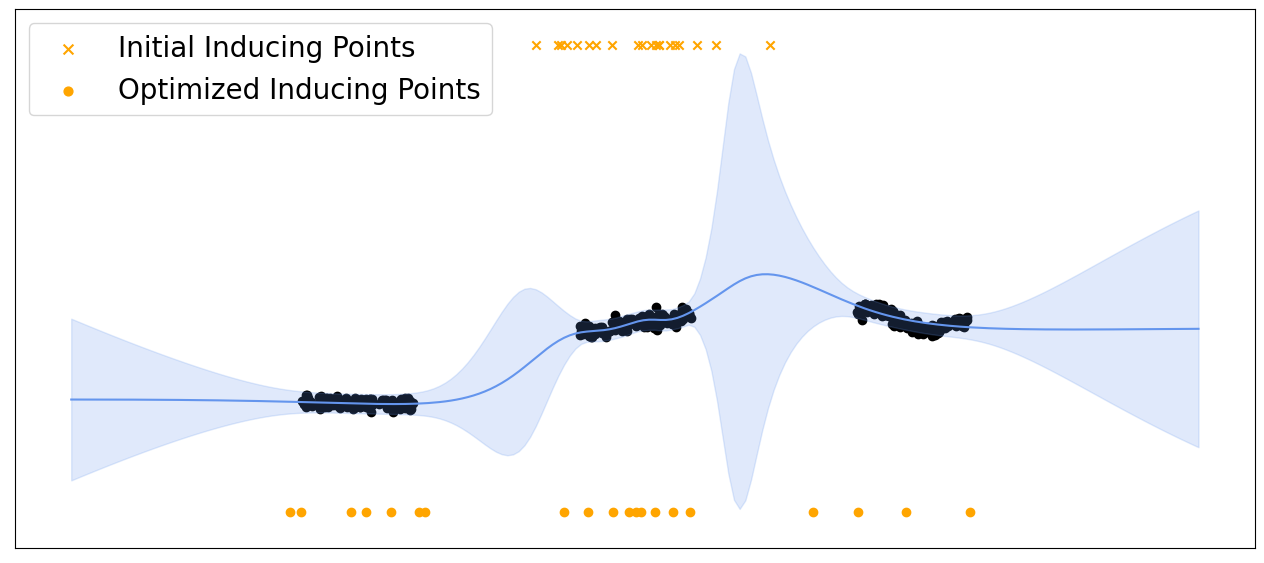

In [36]:
plt.rcParams["pdf.fonttype"] = 42
plt.figure(figsize=(16,7))
mean, var = valla.predict_f(torch.tensor(test_dataset.inputs, dtype = params["dtype"]))
mean = mean.detach().numpy()
var = var.detach().numpy() + np.exp(log_variance)
std = np.sqrt(var).flatten()
sort = np.argsort(test_dataset.inputs.flatten())

fig = plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                color = "black")

plt.plot(
    test_dataset.inputs.flatten()[sort],
    mean.flatten()[sort],
    color="cornflowerblue",
)
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    mean.flatten()[sort] - 2 * std[sort],
    mean.flatten()[sort] + 2 * std[sort],
    alpha=0.2,
    color="cornflowerblue",
)

#plt.axis('off')
plt.ylim(-2.5 ,5)
plt.scatter(Z.flatten(), np.ones(20) * 4.5, marker = "x", color = "orange", label = "Initial Inducing Points")
plt.scatter(valla.inducing_locations.detach().numpy().flatten(), np.ones(20) * -2, marker = "o", 
            color = "orange", label = "Optimized Inducing Points")

lgnd = plt.legend(loc="upper left", fontsize=20)

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [40]
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig("../demos/plots/VaLLA_inducing.pdf", format="pdf", bbox_inches='tight')
plt.show()